# Named Entity Recognition

<div style="border: 2px solid #e0e0e0; border-radius: 10px; padding: 15px; margin: 15px 0;">
  <p>
    Chris Andrei Irag<br>
    University of Science and Technology of Southern Philippines<br>
    <a href="mailto:iragca@pm.me">iragca@pm.me</a><br><br>
    November 2025
 </p>
</div>



## Abstract

This notebook performs Named Entity Recognition building on top of the previous work of dealing with Part-of-Speech tags that used the NLTK library. We focus on using the SpaCy library and compare the results and experience of using both on applying Natural Language Processing on a small corpus taken from one of my favorite books, Test Driven Development: By Example.


---

## Table of Contents


```bash
.
├── Title Section         
│       ├── Abstract   
│       └── Table of Contents   #  ⭐ You are here
├── About the data
├── Preprocessing
├── Part-of-Speech Tagging
│       ├── Results
│       └── Observations
├── Named Entity Recognition
│       ├── Results
│       └── Observations
└── Appendix
        └── Tests
```


# About the data

This paragraph corpus is taken from the the book by Kent Beck "Test-Driven Development: By Example" in Part I: Chapter 2.

This book is about the practice of test-driven development in software engineering.

In [2]:
CORPUS = """The general TDD cycle goes as follows.
1. Write a test. Think about how you would like the operation in your mind to appear in your code. You are writing a story. Invent the interface you wish you had. Include all of the elements in the story that you imagine will be necessary to calculate the right answers.
2. Make it run. Quickly getting that bar to go to green dominates everything else. If a clean, simple solution is obvious, then type it in. If the clean, simple solution is obvious but it will take you a minute, then make a note of it and get back to the main problem, which is getting the bar green in seconds. This shift in aesthetics is hard for some experienced software engineers. They only know how to follow the rules of good engineering. Quick green excuses all sins. But only for a moment.
3. Make it right. Now that the system is behaving, put the sinful ways of the recent past behind you. Step back onto the straight and narrow path of software righteousness. Remove the duplication that you have introduced, and get to green quickly.
The goal is clean code that works (thanks to Ron Jeffries for this pithy summary). Clean code that works is out of the reach of even the best programmers some of the time, and out of the reach of most programmers (like me) most of the time. Divide and conquer, baby. First we'll solve the "that works" part of the problem. Then we'll solve the "clean code" part. This is the opposite of architecture-driven development, where you solve "clean code" first, then scramble around trying to integrate into the design the things you learn as you solve the "that works" problem."""

# Preprocessing

We create a `Pipeline` class where we can string together multiple functions that act as a linear process of preprocessing tasks.

In [3]:
import re
from typing import Any, Callable, Union

import contractions
import nltk
from autocorrect import Speller
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")

class Pipeline:
    """
    A simple function-based processing pipeline.

    Each step is a callable that accepts one argument and returns a value.
    The output of one step is passed as the input to the next.

    Parameters
    ----------
    steps : list of Callable[[Any], Any]
        A list of callables that will be applied in sequence.

    Examples
    --------
    >>> from src.preprocessing import steps as ps
    >>> pipeline = Pipeline([
    ...     ps.to_lowercase,
    ...     ps.remove_punctuation,
    ...     ps.tokenize,
    ...     ps.remove_stopwords,
    ... ])
    >>> result = pipeline("This is an example sentence, with punctuation!")
    >>> print(result)
    ['example', 'sentence', 'punctuation']
    >>> pipeline2 = Pipeline([
    ...     lambda x: x * 5,
    ...     lambda x: x + 2,
    ... ])
    >>> result = pipeline2(3)
    >>> print(result)
    17
    """

    def __init__(self, steps: list[Callable[[Any], Any]]):
        self.steps = steps

    def __call__(self, input: Any) -> Any:
        """
        Execute the pipeline on the provided input.

        Parameters
        ----------
        input : Any
            The initial value to be processed.

        Returns
        -------
        Any
            The final output after applying all steps sequentially.
        """
        value = input
        for step in self.steps:
            value = step(value)
        return value

    def __or__(self, other: Union[Callable, "Pipeline"]) -> "Pipeline":
        """
        Combine this pipeline with another callable or pipeline using the `|` operator.

        Parameters
        ----------
        other : Callable or Pipeline
            If a Pipeline, its steps are appended.
            If a callable, it is added as the final step.

        Returns
        -------
        Pipeline
            A new pipeline with combined steps.
        """
        if isinstance(other, Pipeline):
            return Pipeline(self.steps + other.steps)
        return Pipeline(self.steps + [other])

    def add(self, step: Callable) -> "Pipeline":
        """
        Append a step to the current pipeline.

        Parameters
        ----------
        step : Callable
            A function to append to the pipeline.

        Returns
        -------
        Pipeline
            The pipeline instance (enables chaining).
        """
        self.steps.append(step)
        return self

    def __repr__(self) -> str:
        """
        Return a string representation of the pipeline with visual arrows.

        Returns
        -------
        str
            A formatted representation of the pipeline and its steps.
        """
        indent = "  "
        arrows = "\n    ⬇\n".join(f"{indent}{step.__name__}" for step in self.steps)
        return f"Pipeline(\n{arrows}\n)"

    __str__ = __repr__


def correct_spelling(
    text: str | list[str], speller: Speller = Speller(lang="en")
) -> str | list[str]:
    """
    Correct spelling in the text using an autocorrect speller.

    Parameters
    ----------
    text : str or list of str
        Input string to correct.
    speller : Speller, optional
        Autocorrect speller instance to use, by default a new English `Speller`.

    Returns
    -------
    str or list of str
        The corrected string.
    """
    if isinstance(text, list):
        return [speller(t) for t in text]

    return speller(text)

def remove_punctuation(text: str) -> str:
    """
    Remove all punctuation characters from the string.

    Parameters
    ----------
    text : str
        Input string.

    Returns
    -------
    str
        The string with punctuation removed.

    Notes
    -----
    The regex pattern used is:

    ``r"[^\\w\\s]"``

    - ``\\w`` matches word characters (letters, digits, and underscore).
    - ``\\s`` matches any whitespace character.
    - ``[^...]`` is a negated character class, meaning "anything *not* in this set".

    So the pattern matches any character that is **not**:
    - a letter
    - a digit
    - an underscore
    - whitespace

    All matched characters are replaced with an empty string.

    Examples
    --------
    >>> remove_punctuation("Hello, world!!!")
    'Hello world'
    >>> remove_punctuation("Wait... what?!")
    'Wait what'
    """

    return re.sub(r"[^\w\s]", "", text)

def remove_repeated_characters(text: str) -> str:
    """
    Reduce any character repeated 3 or more times down to 2 occurrences.

    Examples
    --------
    "coooool" -> "cool"

    Parameters
    ----------
    text : str
        Input string.

    Returns
    -------
    str
        The normalized string.

    Notes
    -----
    This function uses the following regular expression:

        ``r"(.)\\1{2,}"``

    Here's what each part does:

    - ``(.)``
      Captures any single character as Group 1.

    - ``\\1``
      A backreference to the character captured by Group 1, ensuring the same
      character is matched again.

    - ``{2,}``
      Specifies that the backreference must appear at least two more times.
      In total, this matches runs of **three or more** of the same character.

    The replacement string ``r"\\1\\1"`` ensures that any run of three or more
    repeated characters is reduced to exactly two.

    Examples
    --------
    >>> remove_repeated_characters("soooo coooool")
    'soo cool'
    >>> remove_repeated_characters("noooooooo wayyyyy")
    'noo wayy'`
    >>> remove_repeated_characters("yeeeessss!!!")
    'yeess!!'
    """
    return re.sub(r"(.)\1{2,}", r"\1\1", text)

def expand_contractions(text: str) -> str:
    """
    Expand contractions in the input string.

    Parameters
    ----------
    text : str
        Input string.

    Returns
    -------
    str
        The expanded string.

    Raises
    ------
    ValueError
        If the contractions library returns a non-string result.

    Examples
    --------
    "can't" -> "cannot"
    """
    result = contractions.fix(text)
    if not isinstance(result, str):
        raise ValueError("Contractions.fix did not return a string")
    return result

def remove_stopwords(tokens: list[str], language: str = "english") -> list[str]:
    """
    Remove common stopwords from a list of tokens.

    Parameters
    ----------
    tokens : list of str
        List of input tokens.
    language : str, optional
        Language of the stopwords to remove. Defaults to "english".

    Returns
    -------
    list of str
        List of tokens with stopwords removed.
    """
    stop_words: list[str] = stopwords.words(language)
    return [token for token in tokens if token not in stop_words]


def lemmatize_tokens(tokens: list[str]) -> list[str]:
    """
    Apply lemmatization to a list of tokens using the WordNet lemmatizer.

    Parameters
    ----------
    tokens : list of str
        List of input tokens.

    Returns
    -------
    list of str
        List of lemmatized tokens.
    """
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def remove_numerics(tokens: list[str]) -> list[str]:
    """
    Remove tokens that are purely numeric.

    Parameters
    ----------
    tokens : list of str
        List of input tokens.

    Returns
    -------
    list of str
        List of tokens with numeric tokens removed.
    """
    return [token for token in tokens if not token.isdigit()]


[nltk_data] Downloading package stopwords to /home/iragca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from nltk import word_tokenize
preprocessing_pipeline = Pipeline([
    str.strip,
    str.lower,
    expand_contractions,
    remove_repeated_characters,
    correct_spelling,
    word_tokenize, # tokenize
])
preprocessing_pipeline

Pipeline(
  strip
    ⬇
  lower
    ⬇
  expand_contractions
    ⬇
  remove_repeated_characters
    ⬇
  correct_spelling
    ⬇
  word_tokenize
)

Our pipeline removes trailing whitespaces, normalizes text to lowercase, expand the contractions of each word, removes all punctuations, remove repeated characters, auto correct the spelling in english, then remove stop words.

In [5]:
processed_data = preprocessing_pipeline(CORPUS)
processed_data

['the',
 'general',
 'add',
 'cycle',
 'goes',
 'as',
 'follows',
 '.',
 '1.',
 'write',
 'a',
 'test',
 '.',
 'think',
 'about',
 'how',
 'you',
 'would',
 'like',
 'the',
 'operation',
 'in',
 'your',
 'mind',
 'to',
 'appear',
 'in',
 'your',
 'code',
 '.',
 'you',
 'are',
 'writing',
 'a',
 'story',
 '.',
 'invent',
 'the',
 'interface',
 'you',
 'wish',
 'you',
 'had',
 '.',
 'include',
 'all',
 'of',
 'the',
 'elements',
 'in',
 'the',
 'story',
 'that',
 'you',
 'imagine',
 'will',
 'be',
 'necessary',
 'to',
 'calculate',
 'the',
 'right',
 'answers',
 '.',
 '2.',
 'make',
 'it',
 'run',
 '.',
 'quickly',
 'getting',
 'that',
 'bar',
 'to',
 'go',
 'to',
 'green',
 'dominates',
 'everything',
 'else',
 '.',
 'if',
 'a',
 'clean',
 ',',
 'simple',
 'solution',
 'is',
 'obvious',
 ',',
 'then',
 'type',
 'it',
 'in',
 '.',
 'if',
 'the',
 'clean',
 ',',
 'simple',
 'solution',
 'is',
 'obvious',
 'but',
 'it',
 'will',
 'take',
 'you',
 'a',
 'minute',
 ',',
 'then',
 'make',
 'a

We run our corpus through our pipeline. We received a list of strings as tokens.

# Part-of-Speech Tagging

In [6]:
from nltk.tag import pos_tag

statistical_tags = pos_tag(processed_data)

statistical_tags

[('the', 'DT'),
 ('general', 'JJ'),
 ('add', 'NN'),
 ('cycle', 'NN'),
 ('goes', 'VBZ'),
 ('as', 'IN'),
 ('follows', 'VBZ'),
 ('.', '.'),
 ('1.', 'CD'),
 ('write', 'PDT'),
 ('a', 'DT'),
 ('test', 'NN'),
 ('.', '.'),
 ('think', 'VB'),
 ('about', 'IN'),
 ('how', 'WRB'),
 ('you', 'PRP'),
 ('would', 'MD'),
 ('like', 'VB'),
 ('the', 'DT'),
 ('operation', 'NN'),
 ('in', 'IN'),
 ('your', 'PRP$'),
 ('mind', 'NN'),
 ('to', 'TO'),
 ('appear', 'VB'),
 ('in', 'IN'),
 ('your', 'PRP$'),
 ('code', 'NN'),
 ('.', '.'),
 ('you', 'PRP'),
 ('are', 'VBP'),
 ('writing', 'VBG'),
 ('a', 'DT'),
 ('story', 'NN'),
 ('.', '.'),
 ('invent', 'VB'),
 ('the', 'DT'),
 ('interface', 'NN'),
 ('you', 'PRP'),
 ('wish', 'VBP'),
 ('you', 'PRP'),
 ('had', 'VBD'),
 ('.', '.'),
 ('include', 'VBP'),
 ('all', 'DT'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('elements', 'NNS'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('story', 'NN'),
 ('that', 'IN'),
 ('you', 'PRP'),
 ('imagine', 'VBP'),
 ('will', 'MD'),
 ('be', 'VB'),
 ('necessary', 'JJ'),
 ('to'

We will use statistical tagging as I believe using rule-based systems for large computational tasks is not scalable. Statistical tagging lets the computer use math to work magic.

## Results

We build a frequency table of POS tags and the number of times they appear in the corpus.

In [7]:
from collections import defaultdict

tag_frequencies = defaultdict(int)

for token in statistical_tags:
    tag_frequencies[token[1]] += 1

sorted_tag_frequencies = sorted(tag_frequencies.items(), key=lambda x: x[1], reverse=True)
sorted_tag_frequencies

[('NN', 51),
 ('DT', 43),
 ('IN', 39),
 ('JJ', 27),
 ('.', 24),
 ('VB', 21),
 ('PRP', 20),
 ('VBZ', 15),
 ('RB', 14),
 ('NNS', 13),
 ('VBP', 11),
 (',', 11),
 ('TO', 9),
 ('CC', 7),
 ('MD', 5),
 ('VBG', 5),
 ('``', 4),
 ("''", 4),
 ('CD', 3),
 ('WRB', 3),
 ('JJS', 3),
 ('PRP$', 2),
 ('VBD', 2),
 ('WDT', 2),
 ('(', 2),
 (')', 2),
 ('PDT', 1),
 ('VBN', 1)]

Plot those frequencies using matplotlib and seaborn with a bar chart.

Text(0.5, 1.0, 'Part-of-Speech Tag Frequencies')

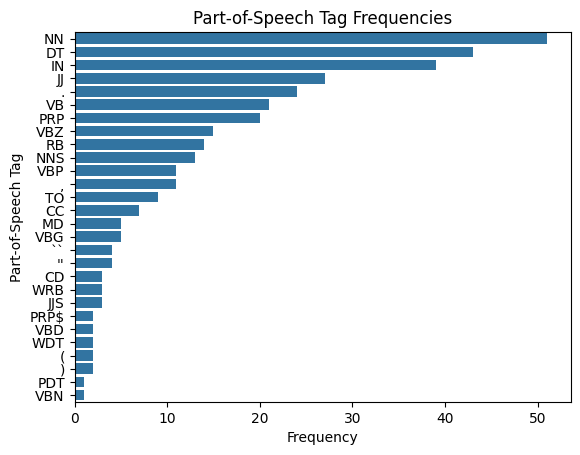

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(
    x=[count for _, count in sorted_tag_frequencies],
    y=[tag for tag, _ in sorted_tag_frequencies],
    orient="h",
)

plt.xlabel("Frequency")
plt.ylabel("Part-of-Speech Tag")
plt.title("Part-of-Speech Tag Frequencies")

## Observations

It seems that the bulk of the paragraph are nouns and their adjectives (NN, JJ & NNS). It is mostly talking about concepts with corresponding action verbs (VBP & RB). Which is correct considering that the corpus data is talking about what Test-Driven Development is and how to do it.

# Named Entity Recognition

We will be doing named entity recognition using [SpaCy](https://spacy.io/). SpaCy uses advanced NLP techniques like using machine/deep learning models for POS and Entity tagging.

In [9]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp(CORPUS)
doc

The general TDD cycle goes as follows.
1. Write a test. Think about how you would like the operation in your mind to appear in your code. You are writing a story. Invent the interface you wish you had. Include all of the elements in the story that you imagine will be necessary to calculate the right answers.
2. Make it run. Quickly getting that bar to go to green dominates everything else. If a clean, simple solution is obvious, then type it in. If the clean, simple solution is obvious but it will take you a minute, then make a note of it and get back to the main problem, which is getting the bar green in seconds. This shift in aesthetics is hard for some experienced software engineers. They only know how to follow the rules of good engineering. Quick green excuses all sins. But only for a moment.
3. Make it right. Now that the system is behaving, put the sinful ways of the recent past behind you. Step back onto the straight and narrow path of software righteousness. Remove the duplica

In [10]:
spacy_freq_table = defaultdict(int)

for token in doc:
    spacy_freq_table[f"{token.pos_} ({token.tag_})"] += 1
    print(f"{token.text}: {token.pos_} ({token.tag_})")

The: DET (DT)
general: ADJ (JJ)
TDD: PROPN (NNP)
cycle: NOUN (NN)
goes: VERB (VBZ)
as: SCONJ (IN)
follows: VERB (VBZ)
.: PUNCT (.)

: SPACE (_SP)
1: X (LS)
.: PUNCT (.)
Write: VERB (VB)
a: DET (DT)
test: NOUN (NN)
.: PUNCT (.)
Think: VERB (VB)
about: ADP (IN)
how: SCONJ (WRB)
you: PRON (PRP)
would: AUX (MD)
like: VERB (VB)
the: DET (DT)
operation: NOUN (NN)
in: ADP (IN)
your: PRON (PRP$)
mind: NOUN (NN)
to: PART (TO)
appear: VERB (VB)
in: ADP (IN)
your: PRON (PRP$)
code: NOUN (NN)
.: PUNCT (.)
You: PRON (PRP)
are: AUX (VBP)
writing: VERB (VBG)
a: DET (DT)
story: NOUN (NN)
.: PUNCT (.)
Invent: NOUN (NN)
the: DET (DT)
interface: NOUN (NN)
you: PRON (PRP)
wish: VERB (VBP)
you: PRON (PRP)
had: VERB (VBD)
.: PUNCT (.)
Include: VERB (VB)
all: PRON (DT)
of: ADP (IN)
the: DET (DT)
elements: NOUN (NNS)
in: ADP (IN)
the: DET (DT)
story: NOUN (NN)
that: PRON (WDT)
you: PRON (PRP)
imagine: VERB (VBP)
will: AUX (MD)
be: AUX (VB)
necessary: ADJ (JJ)
to: PART (TO)
calculate: VERB (VB)
the: DET (DT)
r

## Results

Text(0.5, 1.0, 'SpaCy Part-of-Speech Tag Frequencies')

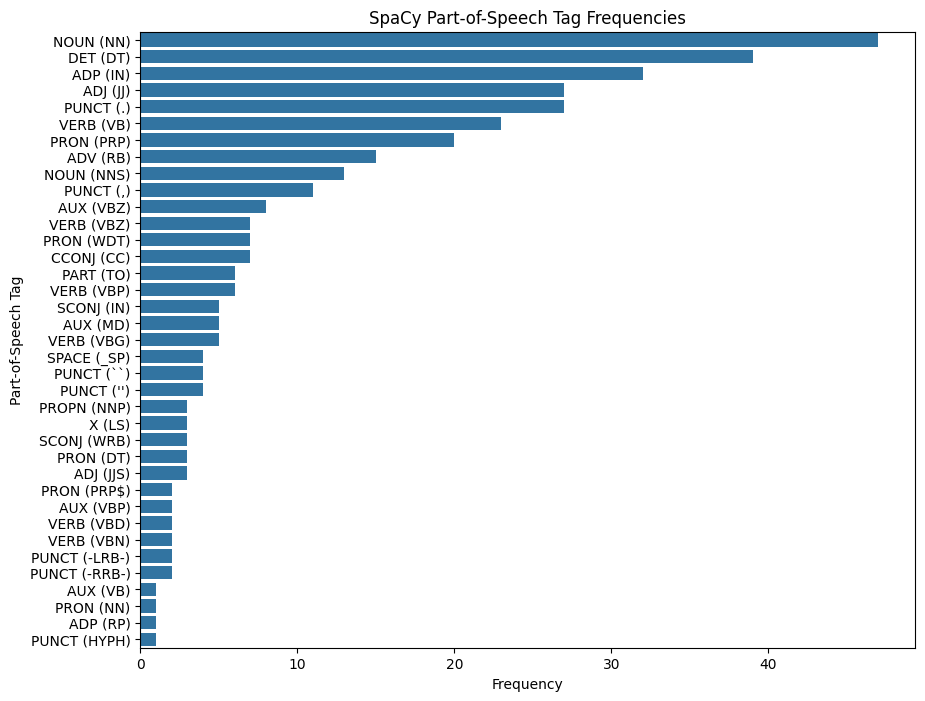

In [11]:
plt.figure(figsize=(10, 8))
sns.barplot(
    x=[count for _, count in sorted(spacy_freq_table.items(), key=lambda x: x[1], reverse=True)],
    y=[tag for tag, _ in sorted(spacy_freq_table.items(), key=lambda x: x[1], reverse=True)],
    orient="h",
)
plt.xlabel("Frequency")
plt.ylabel("Part-of-Speech Tag")
plt.title("SpaCy Part-of-Speech Tag Frequencies")

## Observations

In [12]:
print("NLTK tags: ", len(tag_frequencies))
print("spaCy tags: ", len(spacy_freq_table))

NLTK tags:  28
spaCy tags:  37


Using SpaCy makes POS tagging easy, it does all the preprocessing for us, and gives us a more diverse set of POS tags.

In [13]:
for ent in doc.ents:
    print(f"{ent.text} [{ent.label_}]")

TDD [ORG]
1 [CARDINAL]
2 [CARDINAL]
a minute [TIME]
seconds [TIME]
3 [CARDINAL]
Ron Jeffries [PERSON]
First [ORDINAL]
first [ORDINAL]


SpaCy also does Entity tagging for us. It's get most it correct most of the time, but sometimes like how it tagged TDD as an [ORG] or organization. In essence it is an idealogy or framework, but nothing that can't be fixed with a little of finetuning on pretrained models.

# Appendix

## Tests

In [14]:
def test_remove_punctuation():
    assert remove_punctuation("Hello, world!!!") == "Hello world"
    assert remove_punctuation("Wait... what?!") == "Wait what"

def test_remove_repeated_characters():
    assert remove_repeated_characters("soooo coooool") == "soo cool"
    assert remove_repeated_characters("noooooooo wayyyyy") == "noo wayy"
    assert remove_repeated_characters("yeeeessss!!!") == "yeess!!"

def test_expand_contractions():
    assert expand_contractions("can't") == "cannot"
    assert expand_contractions("I'm happy") == "I am happy"

def test_remove_stopwords():
    tokens = ["this", "is", "an", "example", "sentence"]
    expected = ["example", "sentence"]
    assert remove_stopwords(tokens) == expected

def test_lemmatize_tokens():
    tokens = ["running", "jumps", "easily", "fairly"]
    expected = ["running", "jump", "easily", "fairly"]
    assert lemmatize_tokens(tokens) == expected
def test_remove_numerics():
    tokens = ["hello", "123", "world", "4567"]
    expected = ["hello", "world"]
    assert remove_numerics(tokens) == expected

def test_pipeline():
    pipeline = Pipeline([
        lambda x: x.lower(),
    ])

    assert pipeline("HeLLo") == "hello"

def test_pipeline_combination():
    pipeline1 = Pipeline([
        lambda x: x.lower(),
    ])
    pipeline2 = Pipeline([
        lambda x: x + "!",
    ])
    combined = pipeline1 | pipeline2

    assert combined("HeLLo") == "hello!"


# Run tests
test_remove_punctuation()
test_remove_repeated_characters()
test_expand_contractions()
test_remove_stopwords()
test_lemmatize_tokens()
test_remove_numerics()
test_pipeline()
test_pipeline_combination()